In [ ]:
import pandas as pd
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import time
from datetime import date
import json
import os
from datetime import date
import scipy.stats as st
import math
import pymc3 as pm
from functools import partial

# Sewage, vaccinations, genomics and clinical data

**Notes:** this notebook is not fully executable because clinical data (vaccinations, hospitalizations, new cases and genomics cannot be shared publicly).

### Genomic data

In [5]:
# Data not shared
df_var=pd.read_csv('/mnt/stor/users/francesco.durazzi2/ViralLanguage/pvs_classe_comuni_date.csv')
df_var['Date']=pd.to_datetime(df_var.Date)
var2date=dict(df_var.groupby('Variant')['Date'].min())
sorted([(k,v) for k,v in var2date.items()],key=lambda x: x[1])

[('B.1', Timestamp('2021-01-31 00:00:00')),
 ('C.18', Timestamp('2021-02-19 00:00:00')),
 ('P.1', Timestamp('2021-02-22 00:00:00')),
 ('Q.4', Timestamp('2021-02-22 00:00:00')),
 ('Q.2', Timestamp('2021-04-22 00:00:00')),
 ('Delta', Timestamp('2021-05-17 00:00:00')),
 ('Q.1', Timestamp('2021-05-20 00:00:00')),
 ('C.37', Timestamp('2021-06-03 00:00:00')),
 ('C.36', Timestamp('2021-06-14 00:00:00')),
 ('BA.1', Timestamp('2022-03-19 00:00:00')),
 ('BA.2', Timestamp('2022-03-19 00:00:00'))]

### Vaccination data

<AxesSubplot: xlabel='DATA'>

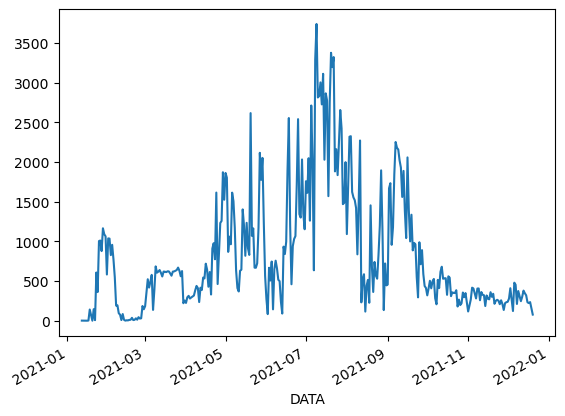

In [9]:
# Data not shared
anag_comune_bo=pd.read_csv('BolognaCovid/data/patients_dataset_v1/ANAGCOMUNEBO.csv',',')
ID_Bologna=anag_comune_bo['ID_PER'].unique()
nabit=len(ID_Bologna)
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
df_vac=pd.read_csv('BolognaCovid/data/patients_dataset_v3/Vaccinati_Unibo_2021-12-20.csv',';',date_parser=dateparse)
df_vac['DATA']=pd.to_datetime(df_vac['DATA'])
df_vac=df_vac[df_vac.ID_PER.isin(ID_Bologna)]
df_vac.sort_values('DATA',inplace=True)
df_vac=df_vac[df_vac.DOSE==2].drop_duplicates(subset=['ID_PER'],keep='last')
df_vac=pd.DataFrame(df_vac.groupby('DATA')['ID_PER'].count()).rename(columns={'ID_PER':'Vaccinations'})
df_vac['VacSum']=df_vac.Vaccinations.cumsum()
df_vac['VaccinatedPerc']=df_vac['VacSum']/len(ID_Bologna)*100
    
df_vac['Vaccinations'].plot()

In [10]:
# Dates were different population coverages were reached
pts=[10,20,50,70]
pt2date={}
for pt in pts:
    pt2date[pt]=df_vac[df_vac.VaccinatedPerc>pt].index[0]
pt2date

{10: Timestamp('2021-04-21 00:00:00'),
 20: Timestamp('2021-05-26 00:00:00'),
 50: Timestamp('2021-08-04 00:00:00'),
 70: Timestamp('2021-11-12 00:00:00')}

### Sewage data

2020-11-24 00:00:00
2022-11-22 00:00:00
Index(['Ct  E gene', 'log 10 viral RNA copies/ul'], dtype='object')


/tmp/ipykernel_8800/1409483967.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df_sew=pd.read_csv('BolognaCovid/data/sewage_2022_2.csv',';')


<AxesSubplot: xlabel='data'>

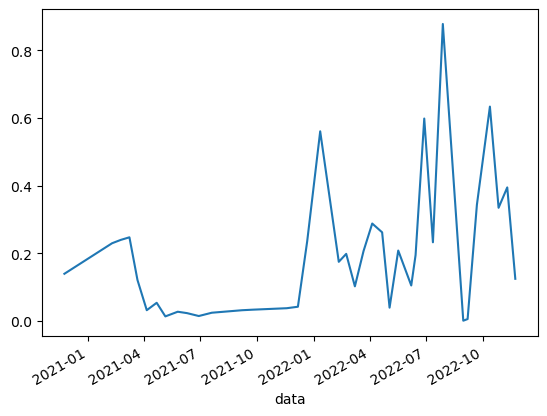

In [17]:
df_sew=pd.read_csv('BolognaCovid/data/sewage_2022_2.csv',';')
df_sew['data']=pd.to_datetime(df_sew['data'],format='%d/%m/%Y')
df_sew.set_index('data', inplace=True)
#df_sew=df_sew.resample('2W').mean().interpolate()
print(df_sew.index.min())
print(df_sew.index.max())
print(df_sew.columns)
#df_sew[['Ct  E gene','log 10 viral RNA copies/ul']].plot()
df_sew['E viral load RNA copies/ul']= (10**df_sew['log 10 viral RNA copies/ul']/10**6).rolling(1).mean() #/1000 to have smaller numbers
df_sew['E viral load RNA copies/ul'].plot()

## Correlations

*df_cov_week* is a dataframe with weekly data (53 weeks) about clinical and sewage data. Not shared for privacy reasons.

In [39]:
df_cov_week.head(2)

,CovidHospitalized,Hospitalized,Covid_ICU,Covid_NO_ICU,Cases,Positivity ratio,Vaccinations,Ct E gene,log 10 viral RNA copies/ul,E viral load RNA copies/ul
2020-11-29,59.166667,267.000000,14.666667,44.500000,345.666667,0.136308,NaN,32.860000,5.143582,0.139182
2020-12-13,54.714286,271.142857,13.785714,40.928571,328.785714,0.114295,NaN,32.701667,5.179753,0.154219


### Figure 2

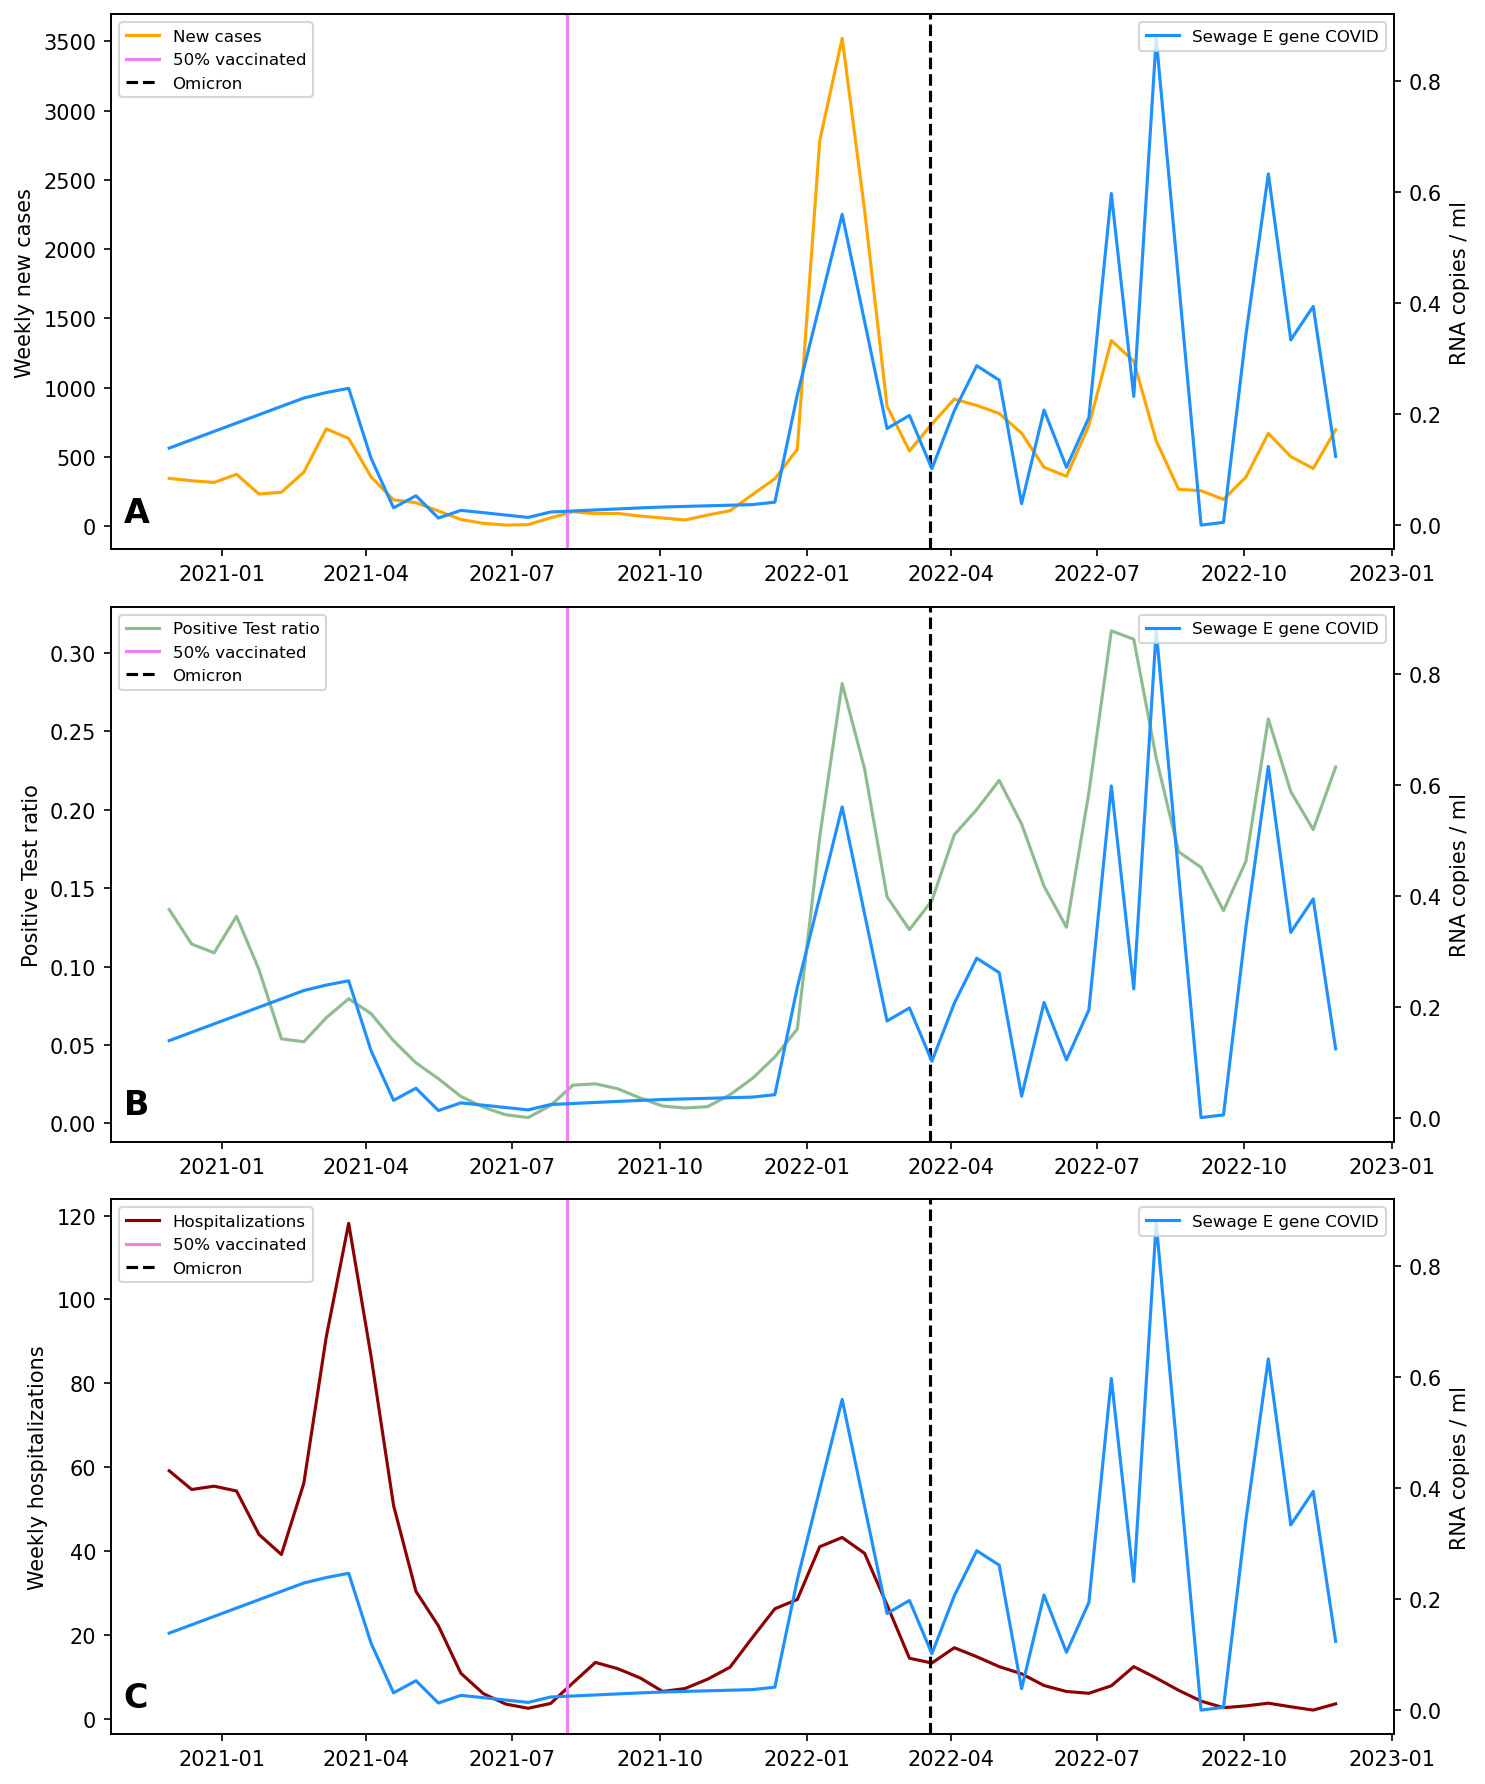

In [20]:
shift=0
f,axs=plt.subplots(3,1,dpi=150,figsize=(10,12))
axs[0].plot(df_cov_week.index,df_cov_week.Cases,label='New cases',color='orange')
for i,pt in enumerate(pt2date):
    if pt==50:
        axs[0].axvline(pt2date[pt],color='violet',label=f'{pt}% vaccinated')#, linestyle='--', dashes=(5, (len(pt2date)-i)*2))
axs[0].axvline(var2date['BA.1'], label='Omicron',color='black',linestyle='--')
axs[0].legend(loc='upper left',prop={'size': 8})
axs[0].set_ylabel('Weekly new cases')
ax01=axs[0].twinx()
ax01.plot(df_cov_week.index,df_cov_week['E viral load RNA copies/ul'].shift(shift),color='dodgerblue', label='Sewage E gene COVID')
ax01.legend(loc='upper right',prop={'size': 8})
ax01.text(0.01, 0.1, 'A', transform=ax01.transAxes,
      fontsize=16, fontweight='bold', va='top')
ax01.set_ylabel('RNA copies / ml')

axs[1].plot(df_cov_week.index,df_cov_week['Positivity ratio'],label='Positive Test ratio',color='darkseagreen')
for i,pt in enumerate(pt2date):
    if pt==50:
        axs[1].axvline(pt2date[pt],color='violet',label=f'{pt}% vaccinated')#, linestyle='--', dashes=(5, (len(pt2date)-i)*2))
axs[1].axvline(var2date['BA.1'], label='Omicron',color='black',linestyle='--')
axs[1].legend(loc='upper left',prop={'size': 8})
axs[1].set_ylabel('Positive Test ratio')
ax11=axs[1].twinx()
ax11.plot(df_cov_week.index,df_cov_week['E viral load RNA copies/ul'].shift(shift),color='dodgerblue', label='Sewage E gene COVID')
ax11.legend(loc='upper right',prop={'size': 8})
ax11.text(0.01, 0.1, 'B', transform=ax11.transAxes,
      fontsize=16, fontweight='bold', va='top')
ax11.set_ylabel('RNA copies / ml')


axs[2].plot(df_cov_week.index,df_cov_week.CovidHospitalized,label='Hospitalizations',color='darkred')
for i,pt in enumerate(pt2date):
    if pt==50:
        axs[2].axvline(pt2date[pt],color='violet',label=f'{pt}% vaccinated')#, linestyle='--', dashes=(5, (len(pt2date)-i)*2))
axs[2].axvline(var2date['BA.1'], label='Omicron',color='black',linestyle='--')
axs[2].legend(loc='upper left',prop={'size': 8})
axs[2].set_ylabel('Weekly hospitalizations')
ax21=axs[2].twinx()
ax21.plot(df_cov_week.index,df_cov_week['E viral load RNA copies/ul'].shift(shift),color='dodgerblue', label='Sewage E gene COVID')
ax21.legend(loc='upper right',prop={'size': 8})
ax21.text(0.01, 0.1, 'C', transform=ax21.transAxes,
      fontsize=16, fontweight='bold', va='top')
ax21.set_ylabel('RNA copies / ml')

plt.tight_layout()
plt.savefig('figures/sewage_viral_load.pdf',dpi=350)

In [21]:
inf_col='Positivity ratio'
#inf_col='Cases'
data=df_cov_week.dropna(subset=[inf_col,'CovidHospitalized','E viral load RNA copies/ul'])
data.shape

(53, 10)

In [26]:
shift=0
print(st.pearsonr(data[inf_col].iloc[shift:], data['E viral load RNA copies/ul'].shift(shift)[shift:]))
print(st.pearsonr( data['E viral load RNA copies/ul'].iloc[shift:],data[inf_col].shift(shift)[shift:]))

(0.7257164349119871, 7.852132553202513e-10)
(0.7257164349119871, 7.852132553202513e-10)


In [107]:
#Before July2022
shift=0
st.pearsonr(data[inf_col].iloc[shift:-5], data['E viral load RNA copies/ul'].shift(shift)[shift:-5])

(0.7147918486865916, 1.1516636634558267e-08)

In [108]:
#After July2022
shift=0
st.pearsonr(data[inf_col].iloc[-5:], data['E viral load RNA copies/ul'].shift(shift)[-5:])

(0.3497551966788337, 0.5639314749999924)

In [18]:
#Before Omicron
shift=0
st.pearsonr(data[inf_col].iloc[shift:-9], data['E viral load RNA copies/ul'].shift(shift)[shift:-9])

(0.821835655980606, 8.058405438674756e-12)

In [19]:
#After Omicron
shift=0
st.pearsonr(data[inf_col].iloc[-9:], data['E viral load RNA copies/ul'].shift(shift)[-9:])

(0.5350382172679263, 0.137727349354492)

## Bayesian model

In [27]:
shift_sr=0
shift_rh=0
days_fit= len(data['E viral load RNA copies/ul'].shift(shift_sr).values[shift_sr:])
tempo=np.linspace(0,days_fit,days_fit+1,dtype=int)
inf_col='Positivity ratio' 
h_col='CovidHospitalized'

tau1_prior=data[data.index<=pd.to_datetime('1/8/2021',format='%d/%m/%Y')].shape[0]-shift_sr
tau2_prior=data[data.index<=pd.to_datetime('15/03/2022',format='%d/%m/%Y')].shape[0]-shift_sr
print(f'1st phase: {data.iloc[:tau1_prior].shape[0]} points')
print(f'2nd phase: {data.iloc[tau1_prior:tau2_prior].shape[0]} points')
print(f'3rd phase: {data.iloc[tau2_prior:].shape[0]} points\n')

sr1_prior=data[inf_col].iloc[:tau1_prior].div(data['E viral load RNA copies/ul'].shift(shift_sr).iloc[:tau1_prior]).mean()
sr1_sigma=data[inf_col].iloc[:tau1_prior].div(data['E viral load RNA copies/ul'].shift(shift_sr)).std()
sr2_prior=data[inf_col].iloc[tau1_prior:tau2_prior].div(data['E viral load RNA copies/ul'].shift(shift_sr).iloc[tau1_prior:tau2_prior]).mean()
sr2_sigma=data[inf_col].iloc[tau1_prior:tau2_prior].div(data['E viral load RNA copies/ul'].shift(shift_sr).iloc[tau1_prior:tau2_prior]).std()
sr3_prior=data[inf_col].iloc[tau2_prior:].div(data['E viral load RNA copies/ul'].shift(shift_sr).iloc[tau2_prior:]).mean()
sr3_sigma=data[inf_col].iloc[tau2_prior:].div(data['E viral load RNA copies/ul'].shift(shift_sr).iloc[tau2_prior:]).std()

rh1_prior=data[h_col].iloc[:tau1_prior].div(data[inf_col].shift(shift_rh).iloc[:tau1_prior]).mean()
rh1_sigma=data[h_col].iloc[:tau1_prior].div(data[inf_col].shift(shift_rh)).std()
rh2_prior=data[h_col].iloc[tau1_prior:tau2_prior].div(data[inf_col].shift(shift_rh).iloc[tau1_prior:tau2_prior]).mean()
rh2_sigma=data[h_col].iloc[tau1_prior:tau2_prior].div(data[inf_col].shift(shift_rh).iloc[tau1_prior:tau2_prior]).std()
rh3_prior=data[h_col].iloc[tau2_prior:].div(data[inf_col].shift(shift_rh).iloc[tau2_prior:]).mean()
rh3_sigma=data[h_col].iloc[tau2_prior:].div(data[inf_col].shift(shift_rh).iloc[tau2_prior:]).std()

1st phase: 18 points
2nd phase: 16 points
3rd phase: 19 points



### Scatter plots

Text(0.08, 0.5, 'Positive tests ratio')

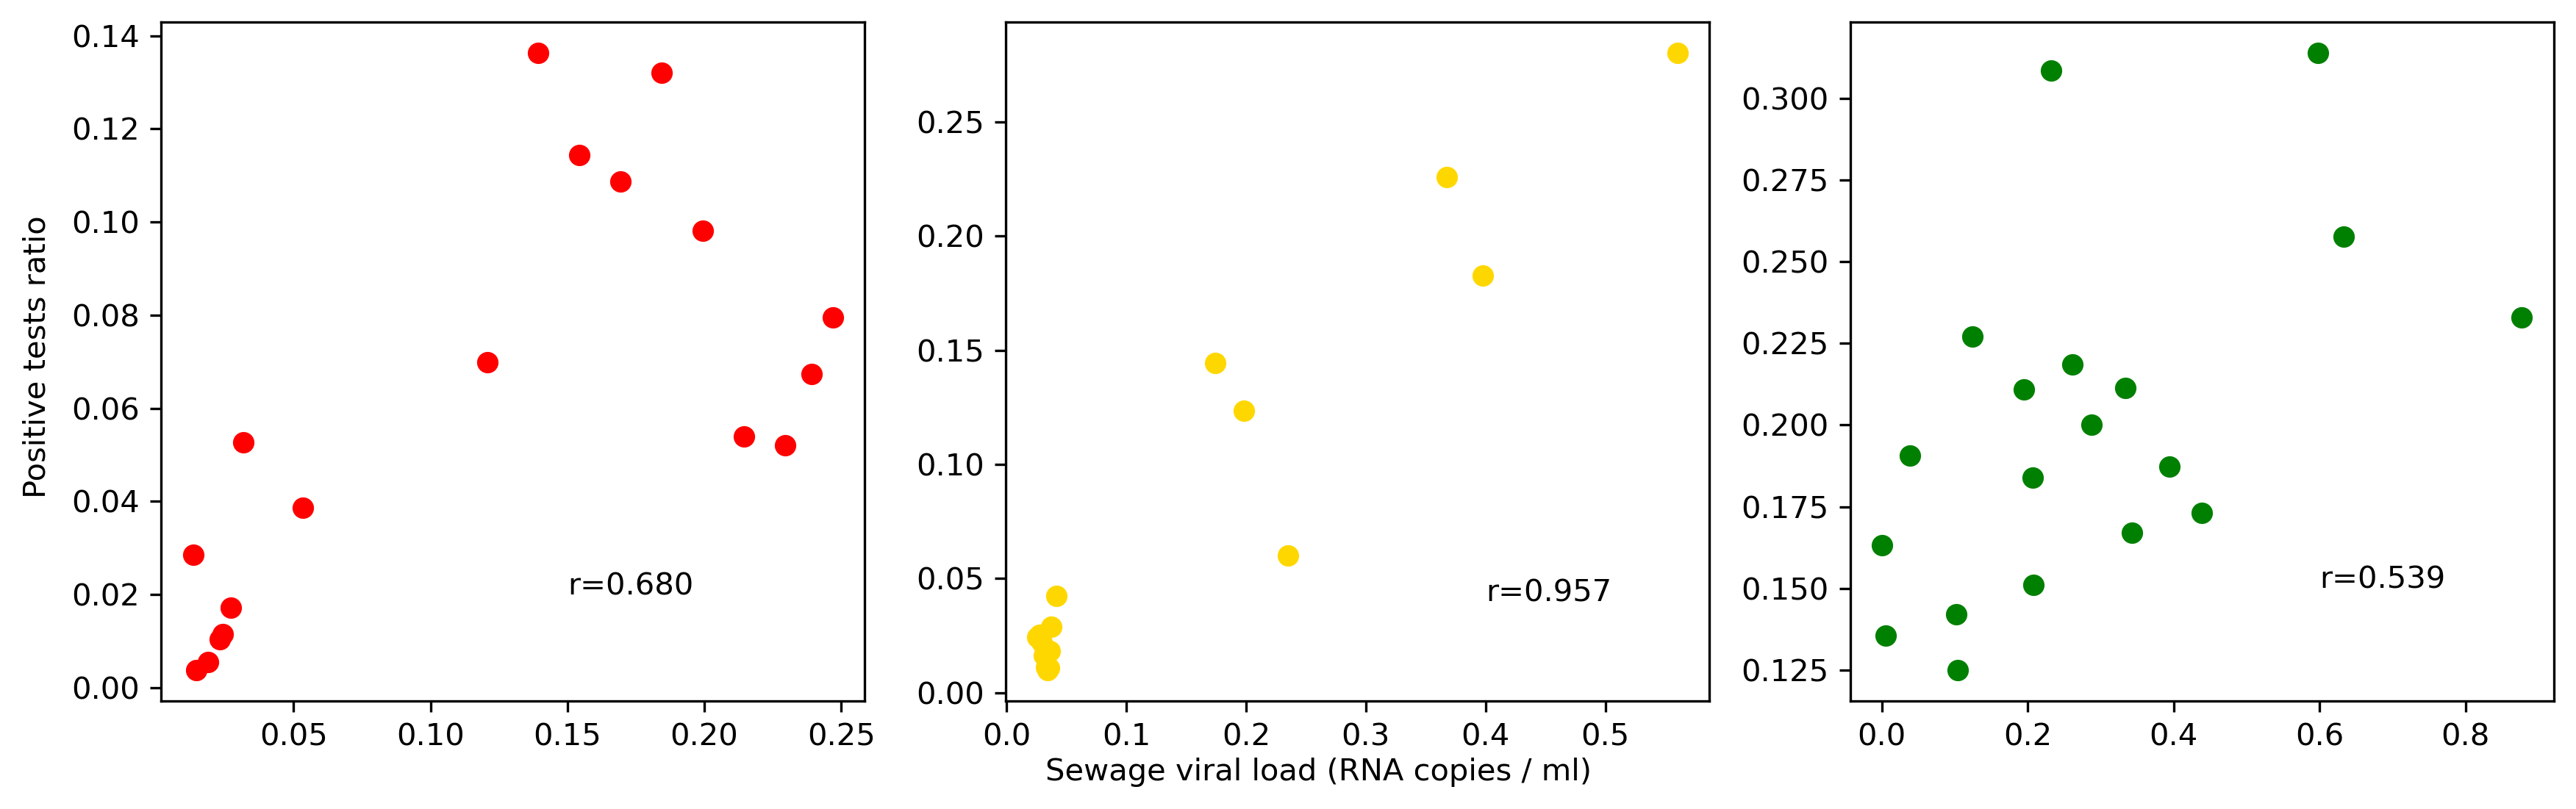

In [22]:
f, axs = plt.subplots(1,3,figsize=(14,4),dpi=300)
axs[0].scatter(data['E viral load RNA copies/ul'].shift(shift_sr).iloc[:tau1_prior],data[inf_col].iloc[:tau1_prior],color='red')
axs[1].scatter(data['E viral load RNA copies/ul'].shift(shift_sr).iloc[tau1_prior:tau2_prior],data[inf_col].iloc[tau1_prior:tau2_prior],color='gold')
axs[2].scatter(data['E viral load RNA copies/ul'].shift(shift_sr).iloc[tau2_prior:],data[inf_col].iloc[tau2_prior:],color='green')

tr=st.pearsonr(data['E viral load RNA copies/ul'].shift(shift_sr).iloc[:tau1_prior],data[inf_col].iloc[:tau1_prior])[0]
axs[0].annotate(f'r={tr:.3f}',(0.15,0.02))
tr=st.pearsonr(data['E viral load RNA copies/ul'].shift(shift_sr).iloc[tau1_prior:tau2_prior],data[inf_col].iloc[tau1_prior:tau2_prior])[0]
axs[1].annotate(f'r={tr:.3f}',(0.4,0.04))
tr=st.pearsonr(data['E viral load RNA copies/ul'].shift(shift_sr).iloc[tau2_prior:],data[inf_col].iloc[tau2_prior:])[0]
axs[2].annotate(f'r={tr:.3f}',(0.6,0.15))

f.text(0.5, 0.02, 'Sewage viral load (RNA copies / ml)', ha='center')
f.text(0.08, 0.5, 'Positive tests ratio', va='center', rotation='vertical')

Text(0.08, 0.5, 'Weekly hospitalizations')

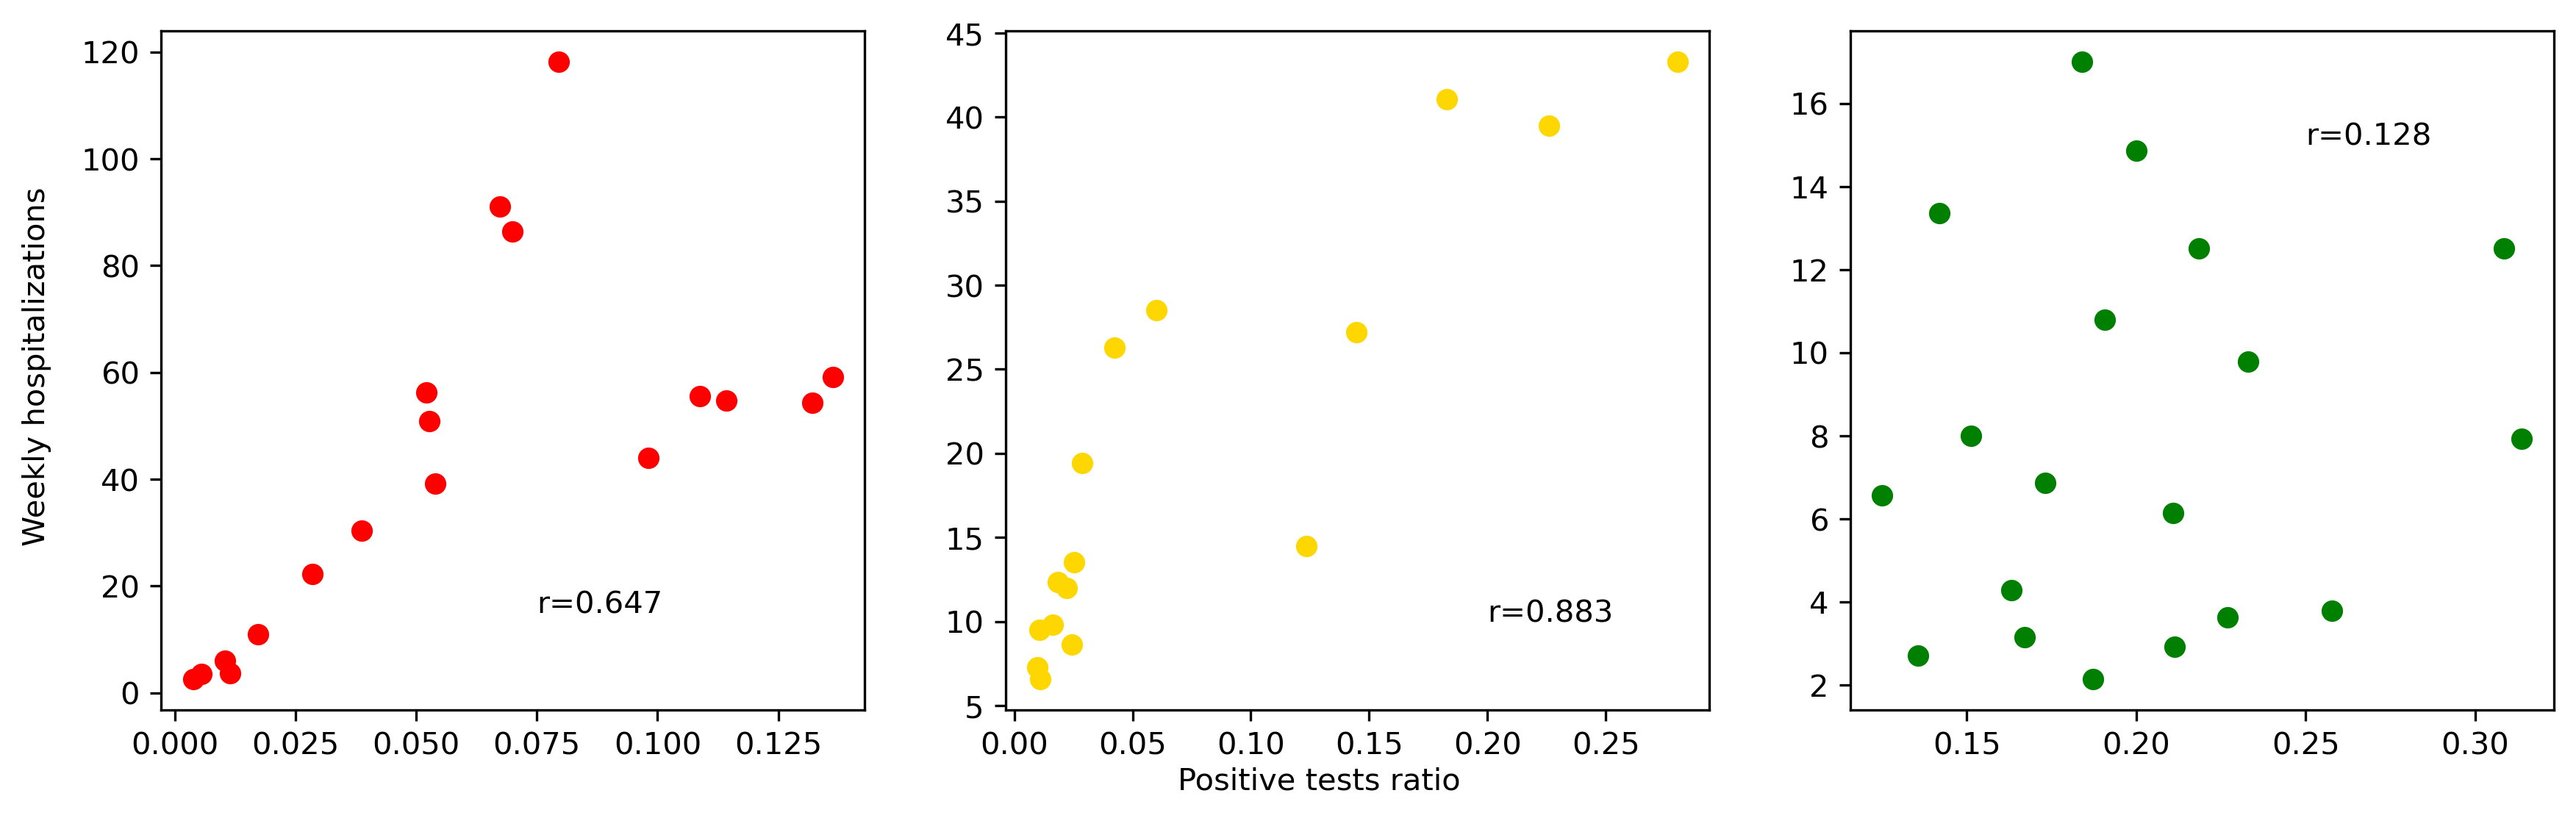

In [24]:
f, axs = plt.subplots(1,3,figsize=(14,4),dpi=300)
axs[0].scatter(data[inf_col].shift(shift_sr).iloc[:tau1_prior],data[h_col].iloc[:tau1_prior],color='red')
axs[1].scatter(data[inf_col].shift(shift_sr).iloc[tau1_prior:tau2_prior],data[h_col].iloc[tau1_prior:tau2_prior],color='gold')
axs[2].scatter(data[inf_col].shift(shift_sr).iloc[tau2_prior:],data[h_col].iloc[tau2_prior:],color='green')

tr=st.pearsonr(data[inf_col].shift(shift_sr).iloc[:tau1_prior],data[h_col].iloc[:tau1_prior])[0]
axs[0].annotate(f'r={tr:.3f}',(0.075,15))
tr=st.pearsonr(data[inf_col].shift(shift_sr).iloc[tau1_prior:tau2_prior],data[h_col].iloc[tau1_prior:tau2_prior])[0]
axs[1].annotate(f'r={tr:.3f}',(0.2,10))
tr=st.pearsonr(data[inf_col].shift(shift_sr).iloc[tau2_prior:],data[h_col].iloc[tau2_prior:])[0]
axs[2].annotate(f'r={tr:.3f}',(0.25,15))

f.text(0.5, 0.02, 'Positive tests ratio', ha='center')
f.text(0.08, 0.5, 'Weekly hospitalizations', va='center', rotation='vertical')

### Fit

In [28]:
print(f'sr1={sr1_prior} +- {sr1_sigma}')
print(f'sr2={sr2_prior} +- {sr2_sigma}')
print(f'sr3={sr3_prior} +- {sr3_sigma}')

print(f'\nrh1={rh1_prior} +- {rh1_sigma}')
print(f'rh2={rh2_prior} +- {rh2_sigma}')
print(f'rh3={rh3_prior} +- {rh3_sigma}')

#print(f'\ntau1: min={tau1_min}, max={tau1_max}')
#print(f'tau2={tau2_prior}')

sr1=0.6613230442626615 +- 0.5075433218958
sr2=0.6002898725701735 +- 0.24566416314243025
sr3=18.48116238769541 +- 70.32258161707477

rh1=753.8608922141349 +- 340.5468103043332
rh2=472.5823662848496 +- 239.5248929208038
rh3=40.92338770752722 +- 25.621508913736314


In [29]:
with pm.Model() as model:    
    s=pm.Data('sewage',data['E viral load RNA copies/ul'].shift(shift_sr).values[shift_sr:])
    p=pm.Data('positives',data[inf_col].shift(shift_rh).values[shift_rh:])
    #tau1=pm.DiscreteUniform('tau1',tau1_min,tau1_max)
    #tau2=pm.DiscreteUniform('tau2',limit+5, days_fit-5)
    sr1= pm.Bound(pm.Normal, lower=0)('sr1',mu=sr1_prior, sigma=sr1_sigma)
    sr2= pm.Bound(pm.Normal, lower=0)('sr2',mu=sr2_prior, sigma=sr2_sigma)
    sr3= pm.Bound(pm.Normal, lower=0)('sr3',mu=sr3_prior, sigma=sr3_sigma)
    
    rh1= pm.Bound(pm.Normal, lower=0)('rh1',mu=rh1_prior, sigma=rh1_sigma)
    rh2= pm.Bound(pm.Normal, lower=0)('rh2',mu=rh2_prior, sigma=rh2_sigma)
    rh3= pm.Bound(pm.Normal, lower=0)('rh3',mu=rh3_prior, sigma=rh3_sigma)
    #R0 = pm.Bound(pm.Normal, lower=1)('R0', mu=3,sigma=1)
    #D = pm.Uniform('D',5,30)
    #gamma=pm.Deterministic('gamma',1/D)
    #beta = pm.Deterministic('beta', gamma*R0)
    #print(r1.shape)
    #print(r2*x[shift+tau1_prior:tau2_prior].shape)
    #@deterministic
    #def lambda_(tau1=tau1, tau2=tau2, r1=r1, r2=r2, r3=r3):
    #out = np.zeros(days_fit)
    #out[:tau1_prior] = r1*x[shift:tau1_prior]  # lambda before tau is lambda1
    #out[tau1_prior:tau2_prior] = r2*x[shift+tau1_prior:tau2_prior]  # lambda after (and including) tau is lambda2
    #out[tau2_prior:] = r3*x[shift+tau2_prior:]
    #    return out
    
    r_counts= pm.Deterministic('positive_estimate',pm.math.concatenate([sr1*s[:tau1_prior],
                                                      sr2*s[tau1_prior:tau2_prior],
                                                        sr3*s[tau2_prior:]],axis=0))
    h_counts= pm.Deterministic('hosp_estimate',pm.math.concatenate([rh1*p[:tau1_prior],
                                                      rh2*p[tau1_prior:tau2_prior],
                                                        rh3*p[tau2_prior:]],axis=0))
    #print(counts.shape)
    # deterministic compartmental model
    #Isol = pm.Deterministic("observed_cases", y_hat.T[1])
    #Rsol = pm.Deterministic("removed", y_hat.T[2])
    
    # data likelihood
    #IL = pm.Poisson('IL', Isol, observed=data.loc[start:end,inf_col]) 
    RL = pm.Poisson('RL', r_counts, observed=data[inf_col].iloc[shift_sr:]) 
    HL= pm.Poisson('HL', h_counts, observed=data['CovidHospitalized'].iloc[shift_rh:])

In [31]:
with model:
    #start = pm.find_MAP()
    step = pm.NUTS(target_accept=0.85)
    #trace = pm.sample(10000, step=step,tune=2000,start=map_estimate)
    #trace=pm.sample(1000,step=step,init='advi',n_init=1000)
    trace=pm.sample(1000,step=step,chains=4)
    sr1_trace= trace['sr1']
    sr2_trace=trace['sr2']
    sr3_trace = trace['sr3']
    #tau1_trace = trace['tau1']
    #tau2_trace = trace['tau2']
    rh1_trace= trace['rh1']
    rh2_trace=trace['rh2']
    rh3_trace = trace['rh3']
    

/tmp/ipykernel_8800/131833532.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace=pm.sample(1000,step=step,chains=4)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rh3, rh2, rh1, sr3, sr2, sr1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [32]:
len(sr1_trace)

4000

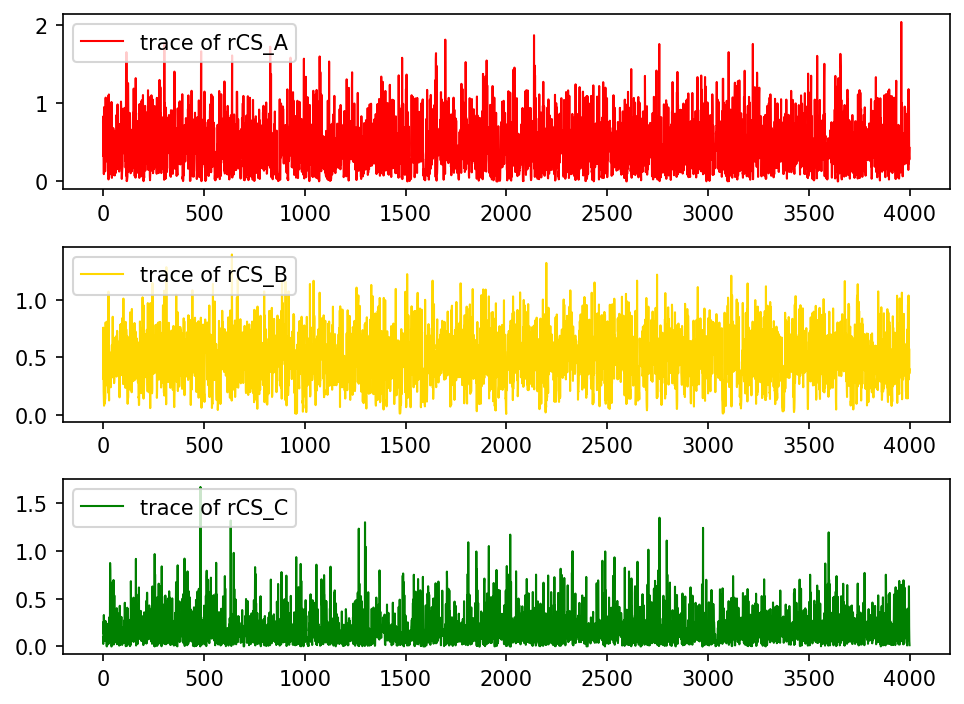

In [33]:
f,axs=plt.subplots(3,1,dpi=150)
lw = 1

#plt.title("Traces of unknown parameters")
axs[0].plot(sr1_trace, label="trace of rCS_A", c='red', lw=lw)
axs[0].legend(loc="upper left")


axs[1].plot(sr2_trace, label="trace of rCS_B", c='gold', lw=lw)
axs[1].legend(loc="upper left")

axs[2].plot(sr3_trace, label="trace of rCS_C", c='green', lw=lw)
axs[2].legend(loc="upper left")

#axs[3].plot(tau1_trace, label="trace of tau1", c='dodgerblue', lw=lw)
#axs[3].legend(loc="upper left")
#leg = plt.legend(loc="upper right")
#leg.get_frame().set_alpha(0.7)
plt.tight_layout()

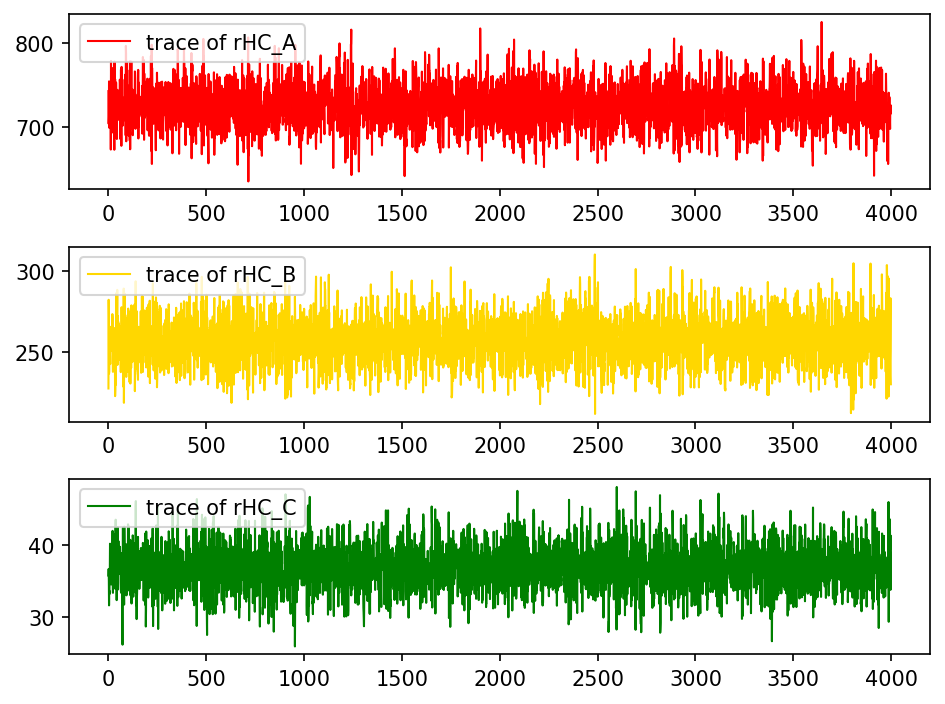

In [34]:
f,axs=plt.subplots(3,1,dpi=150)
lw = 1

#plt.title("Traces of unknown parameters")
axs[0].plot(rh1_trace, label="trace of rHC_A", c='red', lw=lw)
axs[0].legend(loc="upper left")


axs[1].plot(rh2_trace, label="trace of rHC_B", c='gold', lw=lw)
axs[1].legend(loc="upper left")

axs[2].plot(rh3_trace, label="trace of rHC_C", c='green', lw=lw)
axs[2].legend(loc="upper left")

#axs[3].plot(tau1_trace, label="trace of tau1", c='dodgerblue', lw=lw)
#axs[3].legend(loc="upper left")
#leg = plt.legend(loc="upper right")
#leg.get_frame().set_alpha(0.7)
plt.tight_layout()

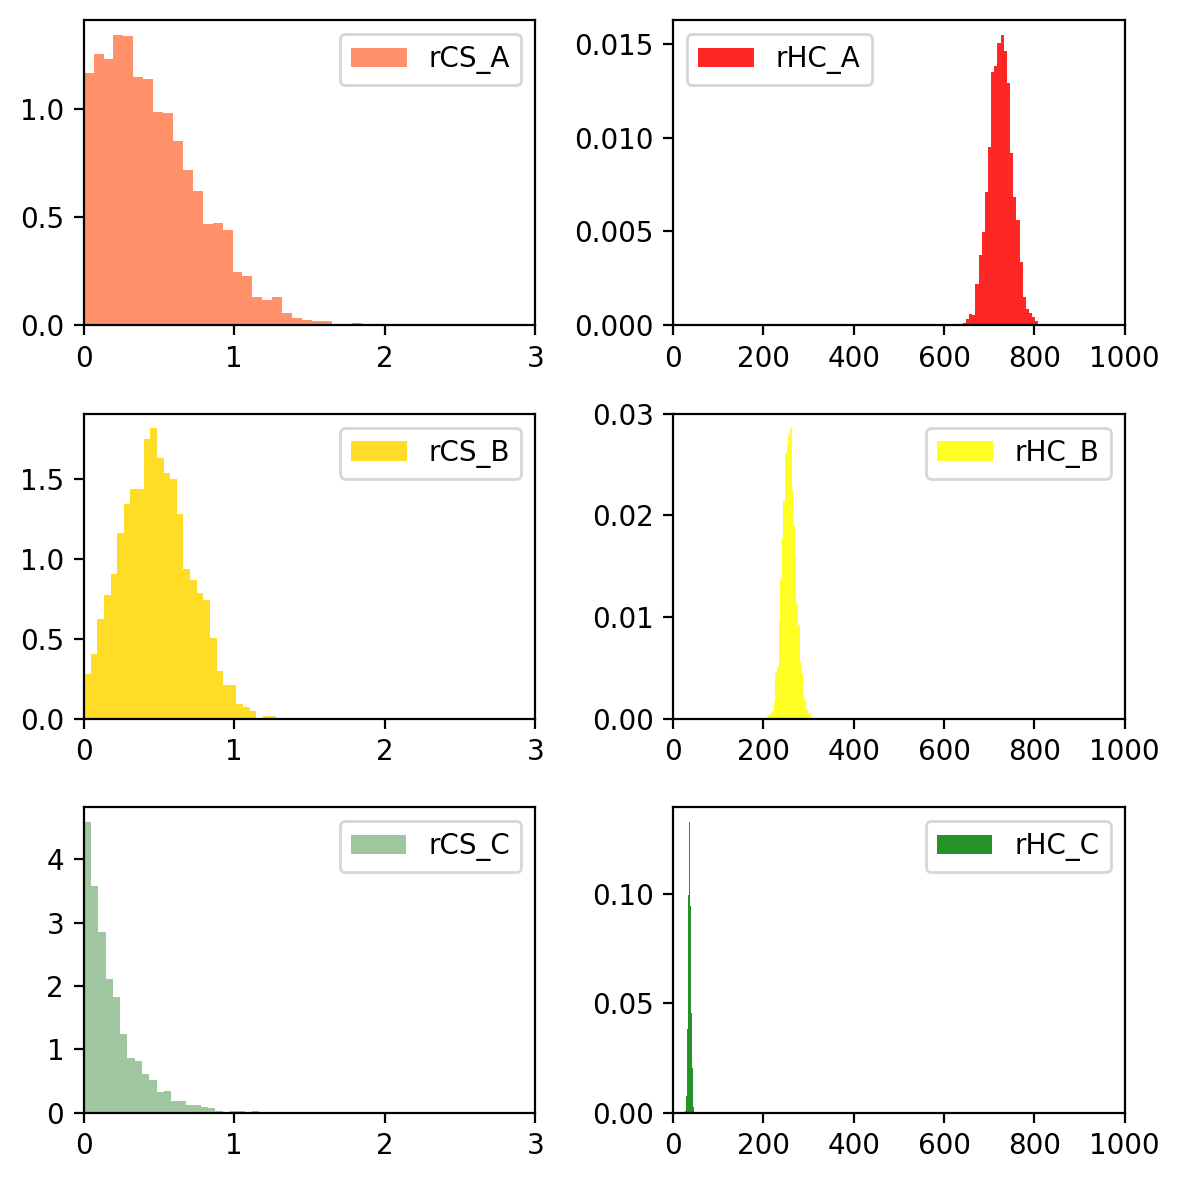

In [49]:
f,axs=plt.subplots(3,2,figsize=(6, 6),dpi=200)
#p_trace = burned_trace["beta"][15000:]
axs[0,0].hist(sr1_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="rCS_A", color="coral")
axs[0,0].legend()
axs[0,0].set_xlim(0,3)
axs[1,0].hist(sr2_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="rCS_B", color="gold")
axs[1,0].legend()
axs[1,0].set_xlim(0,3)
axs[2,0].hist(sr3_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="rCS_C", color="darkseagreen")
axs[2,0].legend();
axs[2,0].set_xlim(0,3)

axs[0,1].hist(rh1_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="rHC_A", color="red")
axs[0,1].legend();
axs[0,1].set_xlim(0,1000)
axs[1,1].hist(rh2_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="rHC_B", color="yellow")
axs[1,1].legend();
axs[1,1].set_xlim(0,1000)
axs[2,1].hist(rh3_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="rHC_C", color="green")
axs[2,1].legend();
axs[2,1].set_xlim(0,1000)

plt.tight_layout()
plt.show()

In [35]:
sr1_b, sr1_bs= np.mean(sr1_trace), np.std(sr1_trace)
sr2_b, sr2_bs= np.mean(sr2_trace), np.std(sr2_trace)
sr3_b, sr3_bs= np.mean(sr3_trace), np.std(sr3_trace)
#tau1_b, tau1_bs= np.mean(tau1_trace), np.std(tau1_trace)
rh1_b, rh1_bs= np.mean(rh1_trace), np.std(rh1_trace)
rh2_b, rh2_bs= np.mean(rh2_trace), np.std(rh2_trace)
rh3_b, rh3_bs= np.mean(rh3_trace), np.std(rh3_trace)

print(f'sr1={sr1_b} +- {sr1_bs}')
print(f'sr2={sr2_b} +- {sr2_bs}')
print(f'sr3={sr3_b} +- {sr3_bs}')
print(f'\nrh1={rh1_b} +- {rh1_bs}')
print(f'rh2={rh2_b} +- {rh2_bs}')
print(f'rh3={rh3_b} +- {rh3_bs}')

#print(f'\ntau1={tau1_b}+-{tau1_bs}')
print(f'Date:{data.index[int(tau1_prior)]}')

sr1=0.45672746797595254 +- 0.33402899635875394
sr2=0.48806810787217875 +- 0.22980179173587706
sr3=0.18203008907457233 +- 0.1790368670387705

rh1=725.5020011849729 +- 26.00438802939457
rh2=256.9938193213176 +- 14.379477124949823
rh3=36.908533389700345 +- 3.162289651960903
Date:2021-08-08 00:00:00


### Figure 3

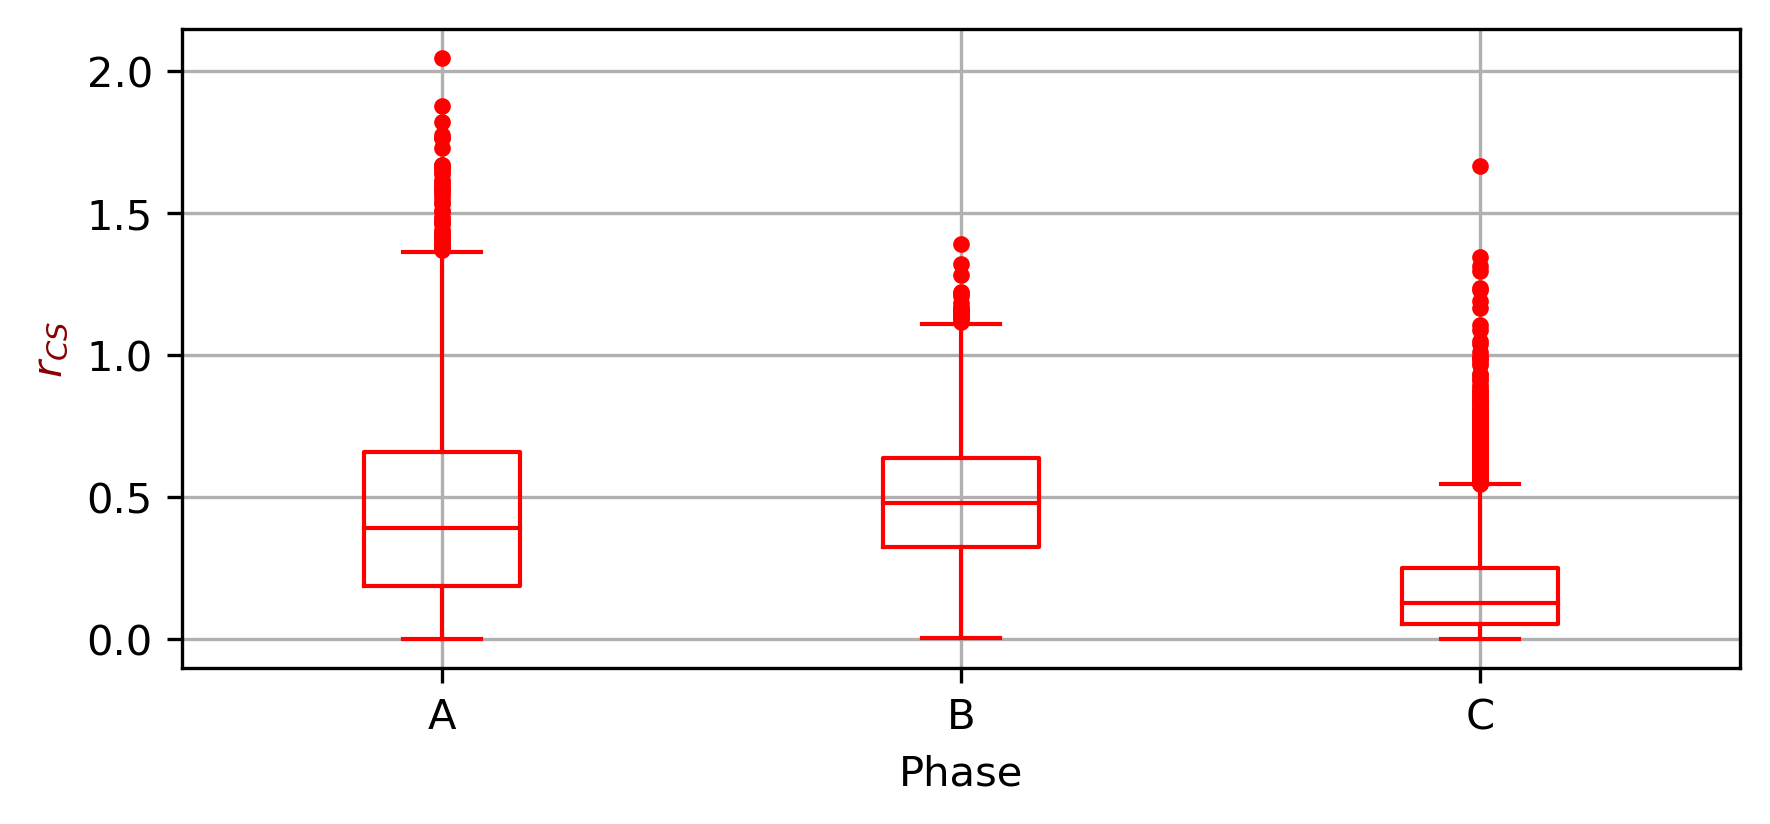

In [36]:
rcs_df=pd.DataFrame(list(sr1_trace)+list(sr2_trace)+list(sr3_trace),columns=['rCS'])
rcs_df['Phase']=['A' for _ in range(len(sr1_trace))]+['B' for _ in range(len(sr2_trace))]+['C' for _ in range(len(sr3_trace))]
rhc_df=pd.DataFrame(list(rh1_trace)+list(rh2_trace)+list(rh3_trace),columns=['rHC'])
rhc_df['Phase']=['A' for _ in range(len(rh1_trace))]+['B' for _ in range(len(rh2_trace))]+['C' for _ in range(len(rh3_trace))]

f,ax0=plt.subplots(1,1,dpi=300,figsize=(6,3))
rcs_df.boxplot('rCS',by='Phase', color='red',ax=ax0,sym='r.')
ax0.set_ylabel('$r_{CS}$',color='darkred')
ax0.set_title('')

fig = ax0.get_figure()
fig.suptitle('')
plt.tight_layout()
plt.savefig('figures/ratios_rCS.pdf',dpi=350)

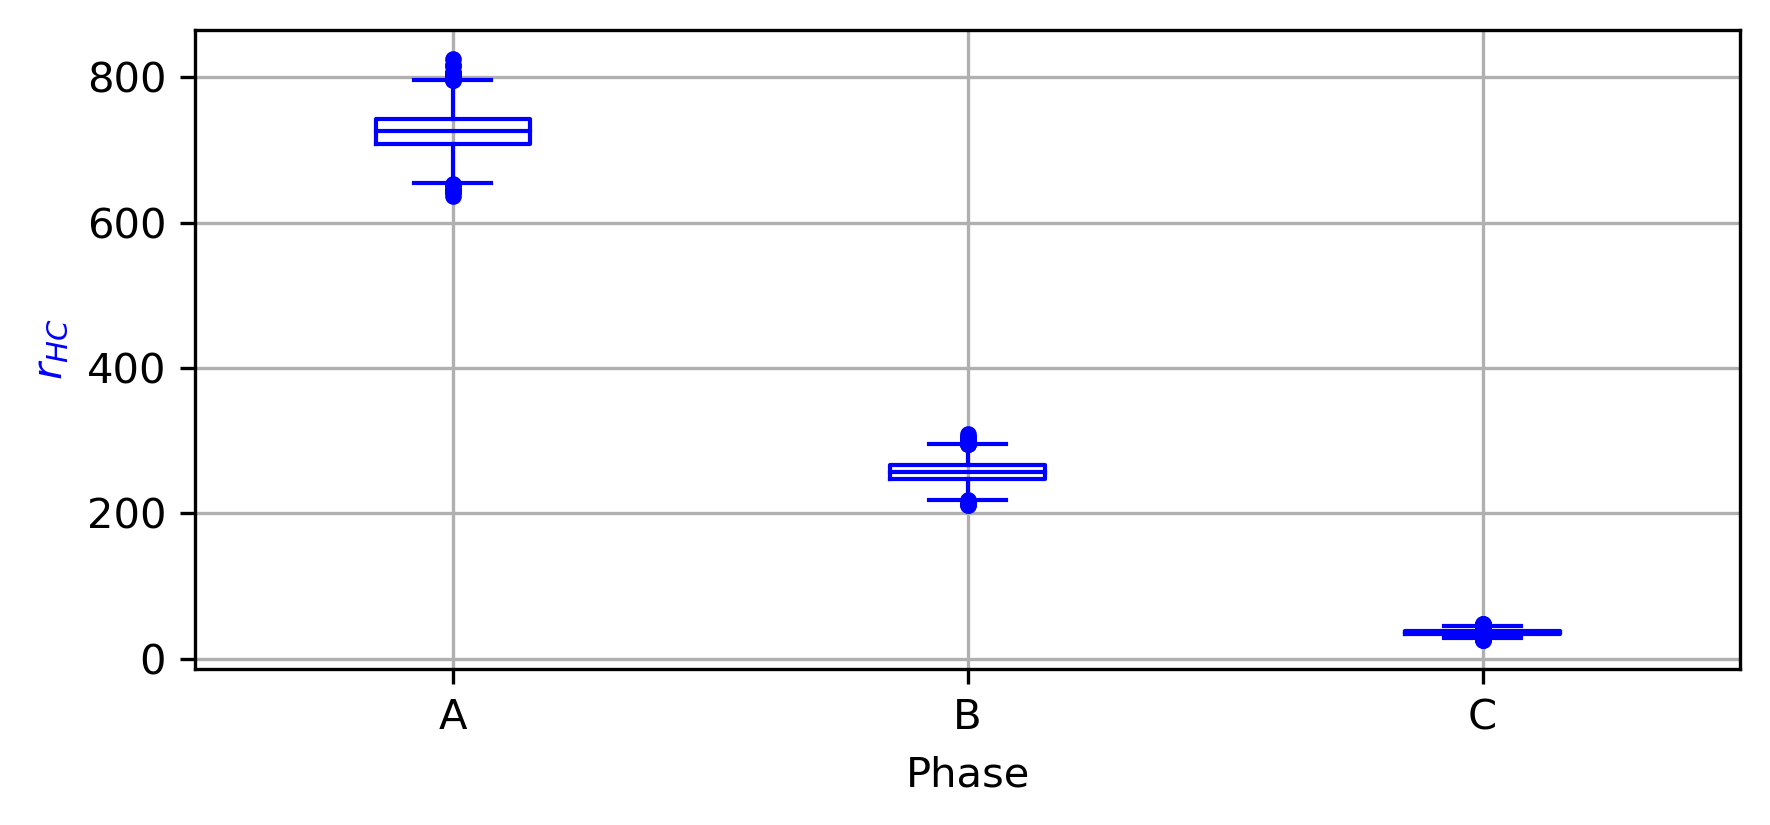

In [37]:
f,ax0=plt.subplots(1,1,dpi=300,figsize=(6,3))
rhc_df.boxplot('rHC',by='Phase', color='blue' ,ax=ax0,sym='b.')
ax0.set_ylabel('$r_{HC}$',color='blue')
plt.xlabel('Phase')
ax0.set_title('')

fig = ax0.get_figure()
fig.suptitle('')
plt.tight_layout()
plt.savefig('figures/ratios_rHC.pdf',dpi=350)

In [35]:
# Perform a two-sample t-test assuming unequal variances
u_statistic, p_value = st.mannwhitneyu(sr3_trace, sr2_trace, alternative='less')

# Set the significance level (alpha)
alpha = 0.01

print(u_statistic,p_value)
# Compare the p-value with the significance level to make a decision
if p_value < alpha:
    print("The first set is lower.")
else:
    print("The two sets are not statistically different.")

2313784.0 0.0
The first set is lower.
